In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
PATH = "../../../data/satellite-imagery/"
sz=256
arch = resnext50 #původně 34
bs=64

In [5]:
torch.cuda.is_available()

True

In [6]:
#MODEL

In [7]:
from planet_copy1 import f2
metrics = [f2]

In [8]:
train_labels_df = pd.read_csv(f"{PATH}train_v2.csv")
n = int(len(train_labels_df)*0.2)
val_idxs=np.array(train_labels_df.sample(n).index)

In [9]:
# different augumentations
def get_data(sz,bs):
    tfms = tfms_from_model(arch,sz,aug_tfms=transforms_top_down,max_zoom=1.05)
    data = ImageClassifierData.from_csv(PATH,folder='train-jpg',csv_fname=f"{PATH}train_v2.csv",
                                        bs=bs,tfms=tfms,val_idxs=val_idxs,test_name='test-jpg',
                                        suffix='.jpg',num_workers=4)
    return data

In [11]:
data = get_data(sz,bs)

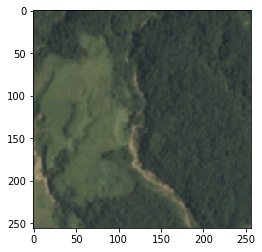

In [25]:
plt.imshow(plt.imread(f'{PATH}{data.val_ds.fnames[0]}'))

In [63]:
len(data.val_ds)/bs,len(data.trn_ds)/bs

(126.484375, 506.0)

In [40]:
x,y = next(iter(data.val_dl))

In [32]:
y


    1     0     0  ...      0     0     1
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

In [41]:
list(zip(data.classes,y[63]))

[('agriculture', 0.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 0.0)]

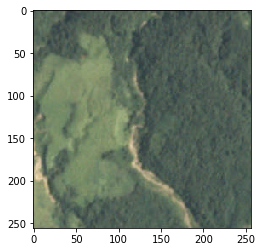

In [45]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4)

In [46]:
data = get_data(sz,bs)

In [47]:
data = data.resize(int(sz*1.3),'tmp')

<function planet_copy1.f2(preds, targs, start=0.17, end=0.24, step=0.01)>

In [54]:
learn = ConvLearner.pretrained(arch,data,ps=0.5,metrics=metrics)


epoch      trn_loss   val_loss   f2                          
    0      0.200751   0.314299   0.82507   



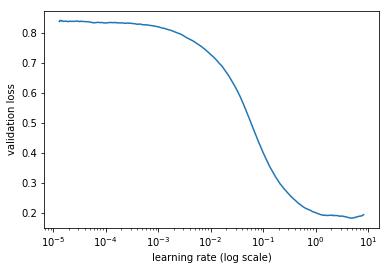

In [55]:
lrf = learn.lr_find()
learn.sched.plot()

In [56]:
lr = 0.2

In [57]:
learn.fit(lr,2,cycle_len=1)

epoch      trn_loss   val_loss   f2                          
    0      0.127898   0.112411   0.903811  
    1      0.121771   0.108495   0.907627                    



[array([0.10849]), 0.9076267932185503]

In [58]:
learn.unfreeze()
lrs=np.array([lr/9,lr/3,lr])

In [59]:
learn.fit(lrs,3,cycle_len=1,cycle_mult=2)

  0%|          | 0/506 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58

In [28]:
learn.save('f{size}')

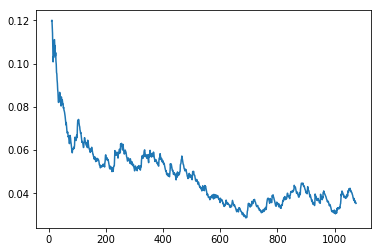

In [30]:
learn.sched.plot_loss()

In [ ]:
sz=128

In [ ]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr,3,cycle_len=1,cycle_mult=2)

In [ ]:
learn.unfreeze()
learn.fit(lrs,3,cycle_len=1,cycle_mult=2)
learn.save('f{size}')

In [ ]:
sz=256

In [ ]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr,3,cycle_len=1,cycle_mult=2)

In [ ]:
learn.unfreeze()
learn.fit(lrs,3,cycle_len=1,cycle_mult=2)
learn.save('f{size}')

In [ ]:
tta = learn.TTA()

In [ ]:
f2(*tta) 

In [16]:
#EVALUACE

In [ ]:
log_preds,y=learn.TTA()
accuracy_np(log_preds,y)

In [23]:
preds = np.argmax(log_preds,axis=1)
probs = np.exp(log_preds[:,1])

In [ ]:
from sklearn.metrics import confussion_matrix
cm = confussion_matrix(y,preds)
plot_confussion_matrix(cm,data.classes)